In [1]:
# Code from Saurabh Gupta
from tqdm import tqdm
import os, sys, numpy as np, cv2
sys.path.insert(0, 'pybsds')
from scipy import signal
from skimage.util import img_as_float
from skimage.io import imread
from pybsds.bsds_dataset import BSDSDataset
from pybsds import evaluate_boundaries
import matplotlib
from scipy.ndimage import gaussian_filter
#matplotlib.use('Agg')
from matplotlib import pyplot as plt

GT_DIR = os.path.join('contour-data', 'groundTruth')
IMAGE_DIR = os.path.join('contour-data', 'images')
N_THRESHOLDS = 99

def get_imlist(name):
    imlist = np.loadtxt('contour-data/{}.imlist'.format(name))
    return imlist.astype(np.int)
def non_matrix_supression(mag, orient, dx,dy):
    new = np.zeros((len(mag),len(mag[0])))
    for i in range(1, len(new)-1):
        for j in range(1, len(new[0])-1):
            if(orient[i,j] >= 0 and orient[i,j] <=45) or (orient[i,j] < -135 and orient[i,j] >= -180):
                p1 = mag[i,j+1]
                p2 = mag[i+1,j+1]
                r1 = mag[i,j-1]
                r2 = mag[i-1,j-1]
                alpha = np.absolute(dy[i,j]/mag[i,j])
                p = ((p2-p1)*alpha+p1)
                r = ((r1-r2)*alpha+r1)
                if (mag[i,j] >= p and mag[i,j] >= r):
                    new[i,j] = mag[i,j]
                else:
                    new[i,j] = 0
            if(orient[i,j] > 45 and orient[i,j] <=90) or (orient[i,j] < -90 and orient[i,j] >= -135):   
                p1 = mag[i+1,j] 
                p2 = mag[i+1,j+1]
                r1 = mag[i-1,j]
                r2 = mag[i-1,j-1]
                alpha = np.absolute(dx[i,j]/mag[i,j])
                p = ((p2-p1)*alpha+p1)
                r = ((r1-r2)*alpha+r1)
                
                if (mag[i,j] >= p and mag[i,j] >= r):
                    new[i,j] = mag[i,j]
                else:
                    new[i,j] = 0
            if(orient[i,j] > 90 and orient[i,j] <=135) or (orient[i,j] < -45 and orient[i,j] >= -90):
                p1 = mag[i+1,j] 
                p2 = mag[i+1,j-1]
                r1 = mag[i-1,j]
                r2 = mag[i-1,j+1]
                alpha = np.absolute(dx[i,j]/mag[i,j])
                p = ((p1-p2)*alpha+p1)
                r = ((r2-r1)*alpha+r1)              
                if (mag[i,j] >= p and mag[i,j] >= r):
                    new[i,j] = mag[i,j]
                else:
                    new[i,j] = 0
            if(orient[i,j] > 135 and orient[i,j] <=180) or (orient[i,j] < 0 and orient[i,j] >= -45):
                p1 = mag[i,j-1]
                p2 = mag[i+1,j-1]
                r1 = mag[i,j+1]
                r2 = mag[i-1,j+1]
                alpha = np.absolute(dx[i,j]/mag[i,j])
                p = ((p2-p1)*alpha+p1)
                r = ((r1-r2)*alpha+r1)
                if (mag[i,j] >= p and mag[i,j] >= r):
                    new[i,j] = mag[i,j]
                else:
                    new[i,j] = 0
    return new
def compute_edges_dxdy(I):
    """Returns the norm of dx and dy as the edge response function."""
    t = (((5 - 1)/2)-0.5)/2
    I = gaussian_filter(I, sigma=2, truncate = t)
    I = I.astype(np.float32)/255.
    #changed 
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary = 'symm')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary = 'symm')
    orient = np.degrees(np.arctan2(dy,dx))
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255)
    mag = mag.astype(np.uint8)
    mag = non_matrix_supression(mag, orient, dx,dy)
    return mag

def detect_edges(imlist, fn, out_dir):
    for imname in tqdm(imlist):
        I = cv2.imread(os.path.join(IMAGE_DIR, str(imname)+'.jpg'))
        gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        mag = fn(gray)
        out_file_name = os.path.join(out_dir, str(imname)+'.png')
        cv2.imwrite(out_file_name, mag)
    

def load_gt_boundaries(imname):
    gt_path = os.path.join(GT_DIR, '{}.mat'.format(imname))
    return BSDSDataset.load_boundaries(gt_path)

def load_pred(output_dir, imname):
    pred_path = os.path.join(output_dir, '{}.png'.format(imname))
    return img_as_float(imread(pred_path))

def display_results(ax, f, im_results, threshold_results, overall_result):
    out_keys = ['threshold', 'f1', 'best_f1', 'area_pr']
    out_name = ['threshold', 'overall max F1 score', 'average max F1 score',
                'area_pr']
    for k, n in zip(out_keys, out_name):
        print('{:>20s}: {:<10.6f}'.format(n, getattr(overall_result, k)))
        f.write('{:>20s}: {:<10.6f}\n'.format(n, getattr(overall_result, k)))
    res = np.array(threshold_results)
    recall = res[:,1]
    precision = res[recall>0.01,2]
    recall = recall[recall>0.01]
    label_str = '{:0.2f}, {:0.2f}, {:0.2f}'.format(
      overall_result.f1, overall_result.best_f1, overall_result.area_pr)
    # Sometimes the PR plot may look funny, such as the plot curving back, i.e,
    # getting a lower recall value as you lower the threshold. This is because of
    # the lack on non-maximum suppression. The benchmarking code does some
    # contour thinning by itself. Unfortunately this contour thinning is not very
    # good. Without having done non-maximum suppression, as you lower the
    # threshold, the contours become thicker and thicker and we lose the
    # information about the precise location of the contour. Thus, a thined
    # contour that corresponded to a ground truth boundary at a higher threshold
    # can end up far away from the ground truth boundary at a lower threshold.
    # This leads to a drop in recall as we decrease the threshold.
    ax.plot(recall, precision, 'r', lw=2, label=label_str)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

Running detector:


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid va

--- 267.77777886390686 time elapsed ---
Evaluating:


100%|██████████| 50/50 [04:12<00:00,  5.04s/it]


           threshold: 0.240000  
overall max F1 score: 0.589014  
average max F1 score: 0.606105  
             area_pr: 0.601814  


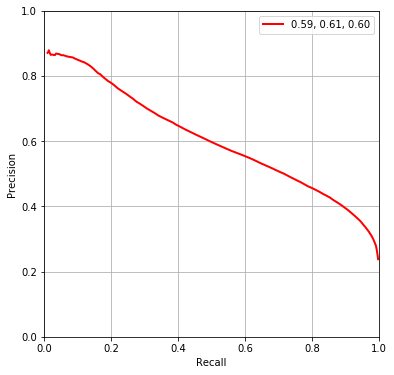

In [2]:
import time
if __name__ == '__main__':
    imset = 'val'
    imlist = get_imlist(imset)
    output_dir = 'contour-output/demo'; fn = compute_edges_dxdy;
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print('Running detector:')
    start_time = time.time()
    detect_edges(imlist, fn, output_dir)
    print("--- %s time elapsed ---" % (time.time() - start_time))
    
    _load_pred = lambda x: load_pred(output_dir, x)
    print('Evaluating:')
    sample_results, threshold_results, overall_result = \
      evaluate_boundaries.pr_evaluation(N_THRESHOLDS, imlist, load_gt_boundaries, 
                                        _load_pred, fast=True, progress=tqdm)
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    file_name = os.path.join(output_dir + '_out.txt')
    with open(file_name, 'wt') as f:
        display_results(ax, f, sample_results, threshold_results, overall_result)
    fig.savefig(os.path.join(output_dir + '_pr.pdf'), bbox_inches='tight')